In [7]:
%%python3 -m venv .venv
%source .venv/bin/activate
%%python3 -m pip install torch numpy==1.21.4 pandas matplotlib pytorch-lightning librosa

In [8]:
# imports
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
import typing

# Project Overview and Motivation

### Modeling Effects Pedals

Since the 1950s, guitarists and other instrumentalists have used effects pedals to achieve certain sounds from their instruments, from overdrive and distortion to reverb and delay. These effects are often encapsulated in physical pedals, each one with different analog circuitry, down to the types of capacitors that go on the pedals, to achieve these different sounds. Musicians will then use these pedals downstream of their instrument signal to apply the effect.

Here is a common signal flow for an overdrive pedal with a guitar:

![signal flow](images/signal-flow.png "Signal Flow")

The guitar produces an input signal, which goes through the overdrive pedal, applying the overdriven effect (a sound that is more distorted and louder) on the raw signal, which then goes through the amplifier, which applies its own sound, and outputs it over its speakers.

### Creating An Effects Pedal Model

Now, the goal of this project is to use machine learning to replace the pedal in the signal chain with software -- a model that emulates the same sound that musicians come to expect when using that pedal.

![signal flow in software](images/signal-flow-sw.png "Signal Flow in Software")

Using an input waveform from the guitar, and an output waveform from the guitar pedal, we can perform supervised learning to achieve this pedal model, completely cutting out the physical pedal in the signal chain altogether!

### Our Setup

For this project, we wanted to model a Boss DS-2 Turbo Distortion Pedal. To achieve this setup and record our dataset, we split the output of the guitar -- one side goes into an input of an audio interface so we can record the raw guitar signal, and the other goes to the pedal, the output of which goes to another input of the audio interface so we can record the distorted guitar signal.

## Analyze audio signals
Our first step is to actually analyze our audio signals. We can use librosa, a package for audio analysis, for this task. What we are essentially doing here is reading from our .wav files and plotting that data on a graph which depicts the amplitude of the wave over time.

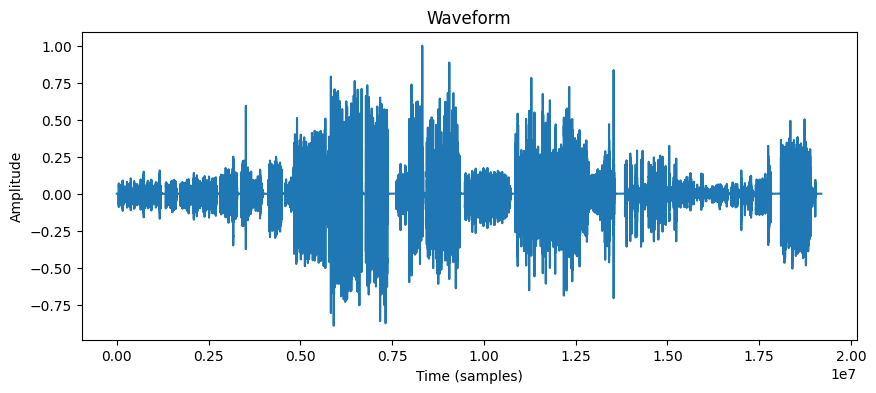

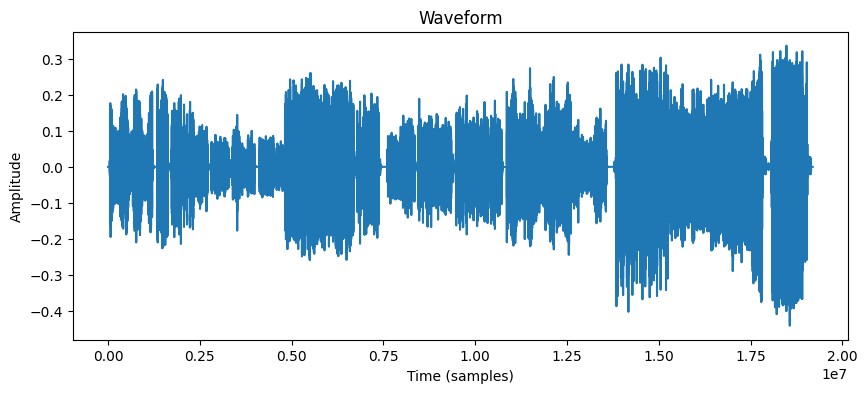

In [9]:
# data exploration to expand on later

def load_audio(file_path: str) -> tuple:
    audio_signal, sampling_rate = librosa.load(file_path, sr=None)
    return audio_signal, sampling_rate

def plot_waveform(wave: np.ndarray) -> None:
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(wave)
    plt.title("Waveform")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

inp_audio_signal, inp_sampling_rate = load_audio("./data/ML_Pedal_Input.wav")
out_audio_signal, out_sampling_rate = load_audio("./data/ML_Pedal_Output.wav")

plot_waveform(inp_audio_signal)
plot_waveform(out_audio_signal)

### Analysis
as can be seen here, the graph for input and output datasets differ drastically

# Machine Learning
We are planning on using a neural network for our machine learning model. 

In [10]:
# turn into tensors for torch

def to_tensor(data: np.ndarray) -> torch.Tensor:
    return torch.tensor(data, dtype=float).unsqueeze(1)

inp_tensor = to_tensor(inp_audio_signal)
out_tensor = to_tensor(out_audio_signal)

print(f"Input Tensor Shape: {inp_tensor.shape}")
print(f"Target Tensor Shape: {out_tensor.shape}")

Input Tensor Shape: torch.Size([19189780, 1])
Target Tensor Shape: torch.Size([19189780, 1])


## Neural Network
WaveNet is our initial neural network for this project. There are five layers in this model, and we will explain our reasoning for using these five layers shortly
1. Input Layer
    - this is our input layer that takes in our raw audio signal and converts it via a 1x1 convolution, which transforms a single-channel raw waveform into multiple feature maps. Feature maps are the output of the 1x1 convolution that lets the model decide which features actually matter (pitch, amplitude, etc.). This makes it so that we do not have to manually select our features, which, due to the vast domain of audio, could lead our model to be overfitted.
2. Dilated Convolution Layers:
3. Residual Connections
4. Skip Connections
5. Output Layer


In [15]:
class WaveNet(nn.Module):
    def __init__(self, num_channels: int = 32, dilation_depth: int = 4, kernel_size: int = 2):
        super(WaveNet, self).__init__()
        self.input_layer = nn.Conv1d(1, num_channels, kernel_size=1)

        dilations = [2 ** i for i in range(dilation_depth)]

        mlist = [nn.Conv1d(num_channels, num_channels, kernel_size, dilation=d) for d in dilations]
        self.dialated_convs = nn.ModuleList(mlist)

        self.output_layer = nn.Conv1d(num_channels, 1, kernel_size=1)

    def forward(self, x: Tensor) -> Tensor:
        out = self.input_layer(x)

        for conv in self.dialated_convs:
            out = torch.tanh(conv(out)) + out

        return self.output_layer(out)

model = WaveNet()
print(model)

WaveNet(
  (input_layer): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
  (dialated_convs): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(2,), stride=(1,))
    (1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(8,))
  )
  (output_layer): Conv1d(32, 1, kernel_size=(1,), stride=(1,))
)
